# Evaluate Ensemble

This notebook combines the classification results of some models via logit-ensembling way.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\bengb\OneDrive\문서\GitHub\eeg_analysis


In [2]:
# Load some packages
import os
import sys
import pickle
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import pprint
import wandb
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.evaluate import calculate_confusion_matrix
from train.evaluate import calculate_class_wise_metrics
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_class_wise_metrics
from train.visualize import draw_error_table
from train.visualize import annotate_heatmap

C:\Users\bengb\anaconda3\envs\eeg_analysis\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0
cuda is available.


-----

## List up the models to check accuracy

In [4]:
model_names = [
    'lo88puq7',
    # '2s1700lg',
    # 'v301o425',
    # '1sl7ipca',
    # 'gvqyvmrj',
    # 'gjkysllw',
    # 'xci5svkl',
    # '1vc80n1f',
    # 'syrx7bmk',
]

model_pool = []

for model_name in model_names:
    path = os.path.join(r'./local\checkpoint', model_name, 'checkpoint.pt')
    try:
        ckpt = torch.load(path, map_location=device)
        model_pool.append({'name': model_name, 'path': path})
    except Exception as e:
        print(e)
        print(f'- checkpoint cannot be opened: {path}')
        
pprint.pprint([model_dict['name'] for model_dict in model_pool])

['lo88puq7']


---

## Configurations

In [5]:
base_repeat = 500  # 500
crop_multiple = 8
test_crop_multiple = 8
verbose = False
save_fig = True
task = 'exp-dementia'

-----

## Evaluate each model and accumulate the logits

In [6]:
for model_dict in model_pool:
    # load and parse the checkpoint
    ckpt = torch.load(model_dict['path'], map_location=device)
    model_state = ckpt['model_state']
    config = ckpt['config']
    
    model_dict['model'] = config['model']
    model_dict['num_params'] = config.get('num_params', '???')
    model_dict['model size (MiB)'] = sys.getsizeof(pickle.dumps(model_state)) / (1024 * 1024)
    # torch.save(model_state, 'temptemptemp.pt')
    
    model_dict['seq_length'] = config['seq_length']
    model_dict['use_age'] = config['use_age']
    model_dict['photic'] = config['photic']
    model_dict['EKG'] = config['EKG']

    model_dict['awgn'] = config.get('awgn', 0)
    model_dict['awgn_age'] = config.get('awgn_age', 0)
    model_dict['mgn'] = config.get('mgn', 0)
    model_dict['mixup'] = config.get('mixup', 0)
    model_dict['dropout'] = config.get('dropout', 0)
    model_dict['weight_decay'] = config.get('weight_decay', '???')
    model_dict['fc_stages'] = config.get('fc_stages', 1)
    model_dict['activation'] = config.get('activation', 0)

    model_dict['minibatch'] = round(config['minibatch'])
    model_dict['total_samples'] = round(config.get('total_samples', config['iterations'] * config['minibatch']))
    model_dict['base_lr'] = config.get('base_lr', config.get('LR', '???'))
    model_dict['lr_scheduler_type'] = config.get('lr_scheduler_type', 'constant_with_decay')
    model_dict['warmup_steps'] = config.get('warmup_steps', '???')
    model_dict['seed'] = config.get('seed', '???')
    
    print('- checking for', model_dict['name'], config['model'], '...')
    
    # initiate the model
    if '_target_' in config:
        model = hydra.utils.instantiate(config).to(device)
    elif type(config['generator']) is str:
        config['generator'] = getattr(models, config['generator'].split('.')[-1])
        if 'block' in config:
            config['block'] = getattr(models, config['block'].split('.')[-1])
        model = config['generator'](**config).to(device)
    else:
        if 'block' in config:
            if config['block'] == models.resnet_1d.BottleneckBlock1D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_2d.Bottleneck2D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_1d.BasicBlock1D:
                config['block'] = 'basic'
            elif config['block'] == models.resnet_2d.BasicBlock2D:
                config['block'] = 'basic'
                
        model = config['generator'](**config).to(device)
    
    if config.get('ddp', False):
        model_state_ddp = deepcopy(model_state)
        model_state = OrderedDict()
        for k, v in model_state_ddp.items():
            name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
            model_state[name] = v
    
    model.load_state_dict(model_state)
    
    # reconfigure and update
    config.pop('cwd', 0)
    config['ddp'] = False
    config['crop_multiple'] = crop_multiple
    config['test_crop_multiple'] = test_crop_multiple
    config['crop_timing_analysis'] = False
    config['eval'] = True
    config['device'] = device
    
    repeat = round(base_repeat / crop_multiple)
    model_dict['repeat'] = repeat
    model_dict['crop_multiple'] = crop_multiple
    model_dict['test_crop_multiple'] = test_crop_multiple
    
    # build dataset
    _ = build_dataset_for_train(config, verbose=verbose)
    train_loader = _[0]
    val_loader = _[1]
    test_loader = _[2]
    multicrop_test_loader = _[3]
    
    # train accuracy
    train_acc = check_accuracy(model, train_loader, 
                               config['preprocess_test'], config, repeat=repeat)
    model_dict['Train Accuracy'] = train_acc
    
    # val accuracy
    val_acc = check_accuracy(model, val_loader, 
                             config['preprocess_test'], config, repeat=repeat)
    model_dict['Validation Accuracy'] = val_acc
    
    # Test accuracy
    _ = check_accuracy_extended(model, test_loader, 
                                config['preprocess_test'], config, repeat=repeat)
    model_dict['Test Throughput'] = _[4]
    model_dict['Test Accuracy'] = _[0]
    model_dict['Test Score'] = _[1]
    model_dict['Test Target'] = _[2]
    test_confusion = _[3]
    test_class_wise_metrics = calculate_class_wise_metrics(test_confusion)
    
    for k, v in test_class_wise_metrics.items():
        for c in range(config['out_dims']):
            c_name = config['class_label_to_name'][c]
            model_dict[f'{k} ({c_name})'] = test_class_wise_metrics[k][c]
            
    if save_fig:
        draw_roc_curve(model_dict['Test Score'], 
                       model_dict['Test Target'], 
                       config['class_label_to_name'], 
                       use_wandb=False, 
                       save_path=f'local/output/imgs/{model_dict["name"]}-ROC.pdf')

        draw_confusion(test_confusion, 
                       config['class_label_to_name'], 
                       use_wandb=False, 
                       save_path=f'local/output/imgs/{model_dict["name"]}-confusion.pdf')

        draw_class_wise_metrics(test_confusion, 
                                config['class_label_to_name'], 
                                use_wandb=False, 
                                save_path=f'local/output/imgs/{model_dict["name"]}-class-wise.pdf')    
    # Multi-crop test accuracy
    _ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                          config['preprocess_test'], config, repeat=repeat)
    model_dict['Multi-Crop Test Throughput'] = _[4]
    model_dict['Multi-Crop Test Accuracy'] = _[0]
    model_dict['Multi-Crop Test Score'] = _[1]
    model_dict['Multi-Crop Test Target'] = _[2]
    multi_test_confusion = _[3]
    multi_test_class_wise_metrics = calculate_class_wise_metrics(multi_test_confusion)
    
    for k, v in multi_test_class_wise_metrics.items():
        for c in range(config['out_dims']):
            c_name = config['class_label_to_name'][c]
            model_dict[f'Multi-Crop {k} ({c_name})'] = multi_test_class_wise_metrics[k][c]
            
    if save_fig:
        draw_roc_curve(model_dict['Multi-Crop Test Score'], 
                       model_dict['Multi-Crop Test Target'], 
                       config['class_label_to_name'], 
                       use_wandb=False, 
                       save_path=f'local/output/imgs/{model_dict["name"]}-roc-tta.pdf')

        draw_confusion(multi_test_confusion, 
                       config['class_label_to_name'], 
                       use_wandb=False, 
                       save_path=f'local/output/imgs/{model_dict["name"]}-confusion-tta.pdf')

        draw_class_wise_metrics(multi_test_confusion, 
                                config['class_label_to_name'], 
                                use_wandb=False, 
                                save_path=f'local/output/imgs/{model_dict["name"]}-class-wise-tta.pdf') 
            
print('==== Finished ====')

- checking for lo88puq7 2D-VGG-19 ...
==== Finished ====


## Conduct ensemble

In [7]:
ensemble_test_score = np.zeros_like(model_pool[0]['Test Score'])
ensemble_multi_test_score = np.zeros_like(model_pool[0]['Multi-Crop Test Score'])

ensemble_test_latency = 0
ensemble_multi_test_latency = 0

ensemble_params = 0
ensemble_model_size = 0

for model_dict in model_pool:
    ensemble_test_score += model_dict['Test Score'] / len(model_pool)
    ensemble_multi_test_score += model_dict['Multi-Crop Test Score'] / len(model_pool)
    
    ensemble_test_latency += 1 / model_dict['Test Throughput']
    ensemble_multi_test_latency += 1 / model_dict['Multi-Crop Test Throughput']
    
    ensemble_params += model_dict['num_params']
    ensemble_model_size += model_dict['model size (MiB)']

In [8]:
# ensemble accuracy
pred = ensemble_test_score.argmax(axis=-1)
ensemble_test_acc = 100.0 * (pred.squeeze() == model_pool[0]['Test Target']).sum() / pred.shape[0]

# class wise metrics
ensemble_test_confusion = calculate_confusion_matrix(pred, model_pool[0]['Test Target'], 
                                                     num_classes=ensemble_test_score.shape[-1])
ensembel_test_class_wise_metrics = calculate_class_wise_metrics(ensemble_test_confusion)

In [9]:
# multi-crop accuracy
pred = ensemble_multi_test_score.argmax(axis=-1)
ensemble_multi_test_acc = 100.0 * (pred.squeeze() == model_pool[0]['Multi-Crop Test Target']).sum() / pred.shape[0]

# class wise metrics
ensemble_multi_test_confusion = calculate_confusion_matrix(pred, model_pool[0]['Multi-Crop Test Target'], 
                                                           num_classes=ensemble_multi_test_score.shape[-1])
ensembel_multi_test_class_wise_metrics = calculate_class_wise_metrics(ensemble_multi_test_confusion)

## Visualize the ensemble results

In [38]:
# draw
save_path = f'local/output/imgs/{task}-ensemble-roc.pdf' if save_fig else None
draw_roc_curve(ensemble_test_score, model_pool[0]['Test Target'], config['class_label_to_name'], 
               use_wandb=False, save_path=save_path)

save_path = f'local/output/imgs/{task}-ensemble-confusion.pdf' if save_fig else None
draw_confusion(ensemble_test_confusion, config['class_label_to_name'], 
               normalize=True, use_wandb=False, save_path=save_path)

save_path = f'local/output/imgs/{task}-ensemble-class-wise.pdf' if save_fig else None
draw_class_wise_metrics(ensemble_test_confusion, config['class_label_to_name'], 
                        use_wandb=False, save_path=save_path)

AttributeError: 'Text' object has no property 'text_face'

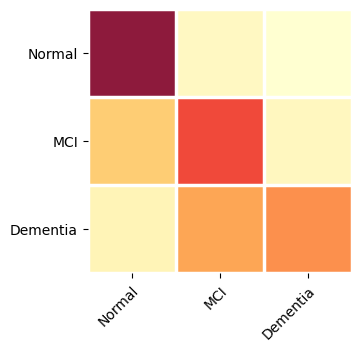

In [31]:
# draw
save_path = f'local/output/imgs/{task}-ensemble-roc-tta.pdf' if save_fig else None
draw_roc_curve(ensemble_multi_test_score, model_pool[0]['Multi-Crop Test Target'], config['class_label_to_name'], 
               use_wandb=False, save_path=save_path)

save_path = f'local/output/imgs/{task}-ensemble-confusion-tta.pdf' if save_fig else None
draw_confusion(ensemble_multi_test_confusion, config['class_label_to_name'], 
               normalize=True, use_wandb=False, save_path=save_path)

save_path = f'local/output/imgs/{task}-ensemble-class-wise-tta.pdf' if save_fig else None
draw_class_wise_metrics(ensemble_multi_test_confusion, config['class_label_to_name'], 
                        use_wandb=False, save_path=save_path)

## Summarize the ensemble results

In [ ]:
ensemble_dict = {}

ensemble_dict['name'] = 'Ensemble'
ensemble_dict['Test Throughput'] = 1 / ensemble_test_latency
ensemble_dict['Test Accuracy'] = ensemble_test_acc
ensemble_dict['Multi-Crop Test Throughput'] = 1 / ensemble_multi_test_latency
ensemble_dict['Multi-Crop Test Accuracy'] = ensemble_multi_test_acc
ensemble_dict['num_params'] = ensemble_params
ensemble_dict['model size (MiB)'] = ensemble_model_size

for k, v in ensembel_test_class_wise_metrics.items():
    for c in range(config['out_dims']):
        c_name = config['class_label_to_name'][c]
        ensemble_dict[f'{k} ({c_name})'] = ensembel_test_class_wise_metrics[k][c]
        
for k, v in ensembel_multi_test_class_wise_metrics.items():
    for c in range(config['out_dims']):
        c_name = config['class_label_to_name'][c]
        ensemble_dict[f'Multi-Crop {k} ({c_name})'] = ensembel_multi_test_class_wise_metrics[k][c]
        
model_pool.append(ensemble_dict)

In [ ]:
for model_dict in model_pool:
    model_dict.pop('Test Score', None)
    model_dict.pop('Test Target', None)
    model_dict.pop('Multi-Crop Test Score', None)
    model_dict.pop('Multi-Crop Test Target', None)

In [ ]:
pd.DataFrame(model_pool)

In [ ]:
pd.DataFrame(model_pool).to_csv(f'local/output/{task}-ensemble.csv')

##### 